In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import load_data as ld
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models

print(tf.__version__)

2.6.0


In [2]:
sst_train, ssh_train, nino34_train = ld.load_train("../data/train_data", op_len=17, with_obs=True)
# obs_sst_train, obs_ssh_train, obs_nino34_train = ld.load_var("../data/train_data/obs", op_len=17)

ACCESS-CM2 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
CanESM2 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CCSM4 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CESM1-CAM5 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CESM2 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
CMCC-CESM data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CMCC-CM data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CMCC-CMS data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CNRM-CM5 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
CNRM-CM6-1 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
CSIRO-Mk3-6-0 data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
FGOALS-f3-L data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
FGOALS-g3 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
FIO-ESM data_shape: (1870, 24, 72) (1870, 24, 72) (1870,)
GFDL-CM4 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
GFDL-ESM4 data_shape: (1978, 24, 72) (1978, 24, 72) (1978,)
MIROC5 data_shape: (1954, 24, 72) (1954, 24, 72)

In [3]:
sst_var, ssh_var, nino34_var = ld.load_var("../data/var_data", op_len=17)

var_data data_shape: (479, 24, 72) (479, 24, 72) (479,)


In [4]:
# 标准化
sst_std = sst_train.std()
ssh_std = ssh_train.std()
nino34_std = nino34_train.std()
print(sst_std, ssh_std, nino34_std)
sst_train, ssh_train, nino34_train = sst_train / sst_std, ssh_train / ssh_std, nino34_train / nino34_std
# obs_sst_train, obs_ssh_train, obs_nino34_train = obs_sst_train / sst_std, obs_ssh_train / ssh_std, obs_nino34_train / nino34_std
sst_var, ssh_var, nino34_var = sst_var / sst_std, ssh_var / ssh_std, nino34_var / nino34_std

0.62603676 0.03388189 0.99235904


In [5]:
ip_var = np.concatenate([sst_var, ssh_var], axis=3)
ip_train = np.concatenate([sst_train, ssh_train], axis=3)
# obs_ip_train = np.concatenate([obs_sst_train, obs_ssh_train], axis=3)
ip_train.shape , nino34_train.shape,ip_var.shape, nino34_var.shape

((42958, 24, 72, 6), (42958, 17), (460, 24, 72, 6), (460, 17))

In [6]:
True in np.isnan(ip_train)

False

In [7]:
# shuffle
ip_train, nino34_train = shuffle(ip_train, nino34_train)

In [23]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (4, 8), padding="same")(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('tanh')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (4, 8), padding="same")(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1) ,padding="same")(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('tanh')(x)
    x = layers.MaxPool2D(2, 2)(x)
    return x
x_inp = keras.layers.Input(ip_train.shape[1:])
x = convolutional_block(x_inp,filter=30)
x = convolutional_block(x,filter=30)
x = layers.Flatten()(x)
x = keras.layers.Dense(30, activation="tanh")(x)
x = keras.layers.Dense(17,use_bias=False)(x)
model = keras.models.Model(inputs = x_inp, outputs = x,name="ENSO")
model.summary()

Model: "ENSO"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 72, 6)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 24, 72, 30)   5790        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 24, 72, 30)   120         conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 24, 72, 30)   0           batch_normalization_8[0][0]      
_______________________________________________________________________________________________

In [24]:
# Pre-train with Model Data
model.compile(optimizer=keras.optimizers.SGD(), loss="mse")
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=6)
hist = model.fit(ip_train, nino34_train, validation_data=(ip_var, nino34_var), epochs=10, 
        batch_size=400,callbacks=[early_stopping, reduce_lr])
model.save("../data/model/resnet")

Epoch 1/10
108/108 [==============================] - 13s 114ms/step - loss: 0.7944 - val_loss: 0.5689
Epoch 2/10
108/108 [==============================] - 12s 111ms/step - loss: 0.6181 - val_loss: 0.5329
Epoch 3/10
108/108 [==============================] - 12s 112ms/step - loss: 0.5627 - val_loss: 0.5509
Epoch 4/10
108/108 [==============================] - 12s 113ms/step - loss: 0.5301 - val_loss: 0.5157
Epoch 5/10
108/108 [==============================] - 12s 114ms/step - loss: 0.5057 - val_loss: 0.4854
Epoch 6/10
108/108 [==============================] - 12s 113ms/step - loss: 0.4857 - val_loss: 0.4624
Epoch 7/10
108/108 [==============================] - 12s 114ms/step - loss: 0.4689 - val_loss: 0.4637
Epoch 8/10
108/108 [==============================] - 12s 114ms/step - loss: 0.4543 - val_loss: 0.4719
Epoch 9/10
108/108 [==============================] - 12s 114ms/step - loss: 0.4403 - val_loss: 0.5249
Epoch 10/10
108/108 [==============================] - 12s 114ms/step - l

C:\Users\ZiluMeng\AppData\Roaming\Python\Python37\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


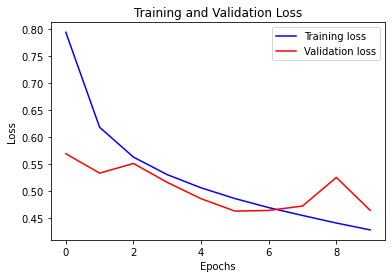

In [25]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    # plt.savefig('../pic/train_prog.png', dpi=300)
    plt.show()


visualize_loss(hist, "Training and Validation Loss")

In [26]:
pre_nino = model.predict(ip_var)
pre_nino.shape, nino34_var.shape

((460, 17), (460, 17))

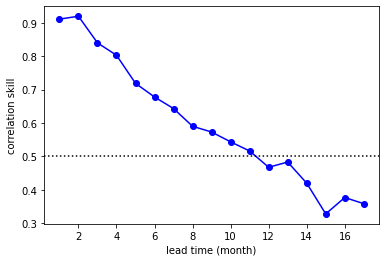

In [27]:
import scipy.stats as sts

corr_ls = []
for i in range(17):
    corr, _ = sts.pearsonr(pre_nino[:,i], nino34_var[:,i])
# corr
    corr_ls.append(corr)
plt.plot(np.arange(1, 18), corr_ls, "o-", color="blue")
plt.xlabel("lead time (month)")
plt.ylabel("correlation skill")
plt.axhline(0.5, color="k", linestyle=":")

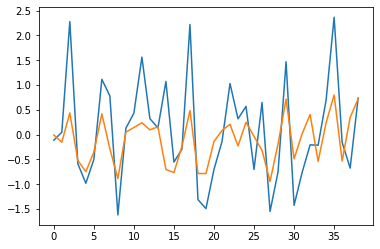

In [31]:
plt.plot(nino34_var[::12,9])
plt.plot(pre_nino[::12,9])